In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [7]:
ticker = "AAPL"
data = yf.download(ticker, start = "2020-01-01", end = "2025-01-01")
data = data[['Close']]

scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data)

def sequence(data, length):
    s = []
    l = []
    for x in range(length, len(data)):
        s.append(data[x - length : x])
        l.append(data[x])
    return np.array(s), np.array(l)
length = 60
X,y = sequence(scaled_data, length)

[*********************100%***********************]  1 of 1 completed


In [8]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

C:\Users\14123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
split = int(len(X * 0.8))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0570
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0050
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0037
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0034
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0033
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0032
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0030
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0034
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0027
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0026


In [14]:
print(X_test.shape)
print(y_test.shape)

(0, 60, 1)
(0, 1)


In [12]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

actual = scaler.inverse_transform(y_test.reshape(-1, 1))

compare = pd.DataFrame({'Actual': actual.flatten(), "Predicted": predictions.flatten()})
print(compare.head())

ValueError: math domain error

Fetching data for AAPL
Sample data retrieved:
                                  Open        High         Low       Close  \
Date                                                                        
2025-01-02 00:00:00-05:00  248.929993  249.100006  241.820007  243.850006   
2025-01-03 00:00:00-05:00  243.360001  244.179993  241.889999  243.360001   
2025-01-06 00:00:00-05:00  244.309998  247.330002  243.199997  245.000000   
2025-01-07 00:00:00-05:00  242.979996  245.550003  241.350006  242.210007   
2025-01-08 00:00:00-05:00  241.919998  243.710007  240.050003  242.699997   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-01-02 00:00:00-05:00  55740700        0.0           0.0  
2025-01-03 00:00:00-05:00  40244100        0.0           0.0  
2025-01-06 00:00:00-05:00  45045600        0.0           0.0  
2025-01-07 00:00:00-05:00  40856000        0.0           0.0  
2025-01-08 00:00:00-05:00  37628900

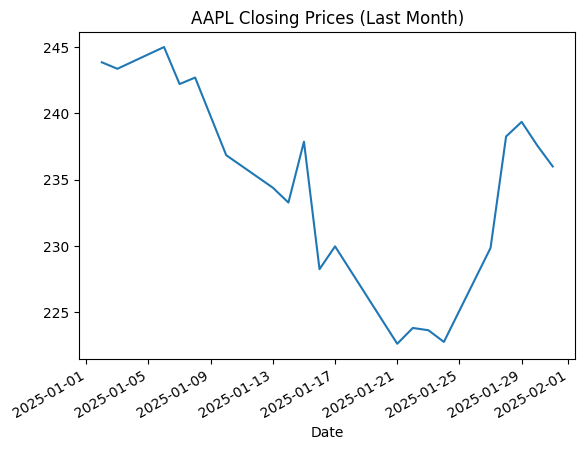

In [2]:
def test_yfinance():
    # Define a sample stock symbol, e.g., Apple Inc.
    stock_symbol = "AAPL"
    
    print("Fetching data for", stock_symbol)
    # Download historical market data for the past month
    try:
        stock_data = yf.Ticker(stock_symbol)
        hist = stock_data.history(period="1mo")

        if hist.empty:
            print("No data retrieved. Please check the stock symbol or date range.")
        else:
            # Print the first few rows of data as a check
            print("Sample data retrieved:\n", hist.head())

        # Show simple statistics
        print("\nStock Info:")
        print(stock_data.info)

        # Get and print the current stock price
        current_price = stock_data.history(period="1d")["Close"].iloc[-1]
        print(f"\nCurrent {stock_symbol} Stock Price: ${current_price:.2f}")

        # Plot historical data
        hist["Close"].plot(title=f"{stock_symbol} Closing Prices (Last Month)")
        
    except Exception as e:
        print("An error occurred while fetching data:", e)

if __name__ == "__main__":
    import matplotlib.pyplot as plt
    test_yfinance()
    plt.show()

In [ ]:


def backtest_strategy(ticker: str, start: str, end: str, initial_cash: float = 10000):
    """
    Backtests a strategy where 1% of holdings are sold for every 1.5% price increase,
    and 1.0125% of holdings are bought for every 1.5% price decrease.
    
    Parameters:
    ticker (str): Stock ticker symbol (e.g., '^GSPC' for S&P 500).
    start (str): Start date in 'YYYY-MM-DD' format.
    end (str): End date in 'YYYY-MM-DD' format.
    initial_cash (float): Starting cash amount.
    
    Returns:
    pd.DataFrame: DataFrame containing portfolio value over time.
    """
    # Download price data
    data = yf.download(ticker, start=start, end=end)["Adj Close"]
    
    if data.empty:
        raise ValueError("No data found for the given stock and time frame.")
    
    # Initialize variables
    cash = initial_cash
    holdings = initial_cash / data.iloc[0]  # Initial holdings based on starting price
    portfolio_value = []
    prev_price = data.iloc[0]
    
    for price in data:
        price_change = (price - prev_price) / prev_price
        
        if price_change >= 0.015:  # Sell 1% of holdings
            sell_amount = 0.01 * holdings
            cash += sell_amount * price
            holdings -= sell_amount
        elif price_change <= -0.015:  # Buy 1.0125% of holdings
            buy_amount = 0.0125 * holdings
            cost = buy_amount * price
            if cash >= cost:
                cash -= cost
                holdings += buy_amount
        
        portfolio_value.append(cash + holdings * price)
        prev_price = price
    
    result = pd.DataFrame({"Date": data.index, "Portfolio Value": portfolio_value})
    return result.set_index("Date")



In [ ]:
# Run backtest
start_date = "2020-02-01"
end_date = "2024-02-01"
ticker = "^GSPC"

test_results = backtest_strategy(ticker, start_date, end_date)
print(test_results.tail())